# TEM Hands‑on  Processing

This notebook walks you through how you can use popular packages in python to do some image processing on the TEM data. In this notebook we use the following

* numpy
* matplotlib
* scikit-learn a free and open-source machine learning library for the Python programming language.


## Pre-requisites

The code below detects and prints out the version for numpy and scikit-learn. We also include helper functions to read an image in gray scale(?) using matplotlib, and also display the image. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    import scipy
    from scipy import ndimage, fft as scipy_fft
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False
try:
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    HAS_SKLEARN = True
except Exception:
    HAS_SKLEARN = False

def imread_gray(path):
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    if img.ndim == 3:
        img = img.mean(axis=2)
    img = img.astype(float)
    vmin, vmax = float(img.min()), float(img.max())
    if vmax - vmin > 0:
        img = (img - vmin) / (vmax - vmin)
    return img

def show_image(a, title="Image"):
    plt.figure(figsize=(5,5))
    plt.imshow(a)
    plt.title(title); plt.axis("off"); plt.show()

print("NumPy:", np.__version__)
print("SciPy:", HAS_SCIPY, " | scikit-learn:", HAS_SKLEARN)


NumPy: 1.19.3
SciPy: True  | scikit-learn: True


## Data paths

Below are some variables that are paths to the files being analyzed. This notebook generates synthetic images and that is why the paths are empty strings.

If you are working on the datasets from the microscope, you will need to provide full path to the files.

In [2]:
# Exercise 1 image path
EX1_IMAGE_PATH = "" 
EX2_SAED_PATH  = ""
EX4_IMAGE_PATH = ""
EX5_CUBE_PATH  = ""
EX5_CSV_SHAPE  = (40, 40, 100)


## Exercise 1 — Image preprocessing & filtering

In this exercvise, we load a TEM micrograph (e.g., high-resolution TEM image of a grain boundary) as a NumPy array, normalize intensities, and apply FFT filtering to remove high-frequency noise.

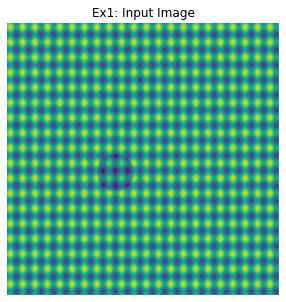

(512, 512) float64 0.0 0.9999999999998231


In [3]:
# check if there is an image file to be analyzed
if EX1_IMAGE_PATH:
    try:
        img1 = imread_gray(EX1_IMAGE_PATH)
    except Exception as e:
        # unable to read the file.
        print("EX1 read failed, will use synthetic data.", e); 
        EX1_IMAGE_PATH = ""

# generate synthetic data
if not EX1_IMAGE_PATH:
    H,W=512,512;
    y=np.linspace(0,1,H,endpoint=False); 
    x=np.linspace(0,1,W,endpoint=False)
    X,Y=np.meshgrid(x,y); 
    rng=np.random.default_rng(0)
    lattice=np.sin(2*np.pi*22*X)+np.sin(2*np.pi*18*Y)
    cy,cx,r=int(H*0.55),int(W*0.40),35
    yy,xx=np.ogrid[:H,:W]; 
    defect=(yy-cy)**2+(xx-cx)**2<=r**2
    img1=lattice+rng.normal(0,0.15,(H,W)); 
    img1[defect]-=0.8
    img1=(img1-img1.min())/(img1.max()-img1.min()+1e-12)

# display the image
show_image(img1, "Ex1: Input Image")
print(img1.shape, img1.dtype, float(img1.min()), float(img1.max()))


### Normalization

Below we generate a histogram showing ?? and also normalize the intensities in the images.

mean, std: 0.5611698468659049 0.1797599902086565


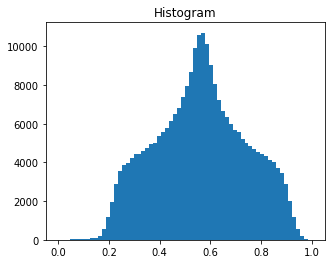

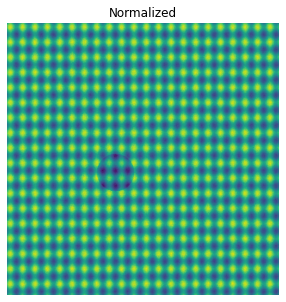

In [4]:
print("mean, std:", float(img1.mean()), float(img1.std()))
plt.figure(figsize=(5,4)); 
plt.hist(img1.ravel(), bins=64); 
plt.title("Histogram"); 
plt.show()
mn,mx=float(img1.min()), float(img1.max()); 

img1_norm=(img1-mn)/(mx-mn+1e-12)
show_image(img1_norm, "Normalized")

### Apply FFT filtering to remove high frequency noise

Add text about what is being done ???.

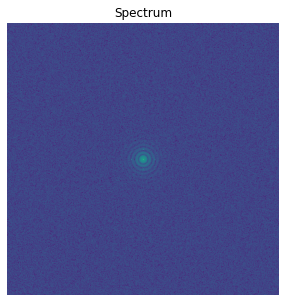

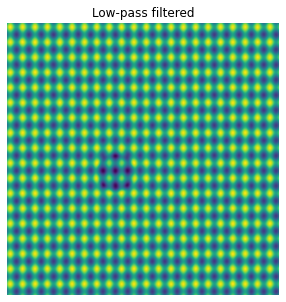

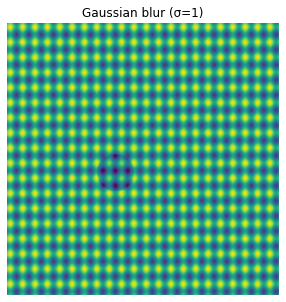

In [5]:
if HAS_SCIPY:
    F=scipy_fft.fftshift(scipy_fft.fft2(img1_norm))
else:
    F=np.fft.fftshift(np.fft.fft2(img1_norm))

plt.figure(figsize=(5,5));
plt.imshow(np.log1p(np.abs(F))/np.log1p(np.abs(F)).max());
plt.title("Spectrum"); 
plt.axis("off");
plt.show()

H,W=img1_norm.shape;
cy,cx=H//2,W//2;
Y,X=np.ogrid[:H,:W]; 
radius=50; 
mask=(Y-cy)**2+(X-cx)**2<=radius**2
Flow=F*mask

if HAS_SCIPY: 
    img_low=scipy_fft.ifft2(scipy_fft.ifftshift(Flow)).real
else: 
    img_low=np.fft.ifft2(np.fft.ifftshift(Flow)).real

mn,mx=img_low.min(),img_low.max(); img_low=(img_low-mn)/(mx-mn+1e-12)
show_image(img_low, "Low‑pass filtered")

if HAS_SCIPY:
    show_image(ndimage.gaussian_filter(img1_norm,1.0), "Gaussian blur (σ=1)")


## Exercise 2 — Diffraction pattern peak picking

In this exercise, we automate the detection of diffraction spots in selected area electron diffraction (SAED) patterns using NumPy + scikit-image peak local maxima detection.

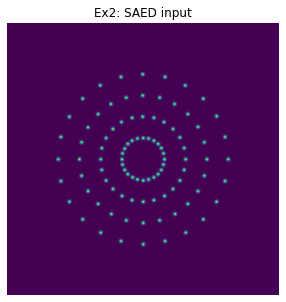

In [6]:
# check if there is an image file to be analyzed
if EX2_SAED_PATH:
    try: saed=imread_gray(EX2_SAED_PATH)
    except Exception as e:
        print("EX2 read failed, using synthetic.", e); 
        EX2_SAED_PATH=""

# generate synthetic data
if not EX2_SAED_PATH:
    H,W=512,512; saed=np.zeros((H,W)); cy,cx=H//2,W//2
    for r in [40,80,120,160]:
        for ang in np.linspace(0,2*np.pi,24,endpoint=False):
            y=int(cy+r*np.sin(ang)); x=int(cx+r*np.cos(ang))
            if 0<=y<H and 0<=x<W: saed[y,x]=1.0
    if HAS_SCIPY: saed=ndimage.gaussian_filter(saed,2.0)
    else:
        k=np.ones((5,5))/25.0; pad=2; padimg=np.pad(saed,pad,mode='edge'); out=np.zeros_like(saed)
        for i in range(H):
            for j in range(W):
                out[i,j]=np.sum(padimg[i:i+5,j:j+5]*k)
        saed=out
    saed=(saed-saed.min())/(saed.max()-saed.min()+1e-12)
show_image(saed, "Ex2: SAED input")


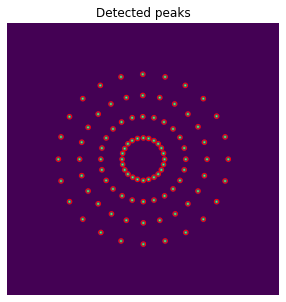

Saved ex2_peaks.csv (first 5):
[['y', 'x', 'r_pixels', 'd_est_m'], [96, 255, 160.00312496948303, 1.2549754889993434e-09], [101, 214, 160.58953888718904, 1.2503927801988276e-09], [101, 297, 160.3309078125612, 1.2524097988314905e-09], [117, 175, 160.87883639559305, 1.2481442836038595e-09], [117, 335, 159.88120589988054, 1.2559324835574686e-09]]


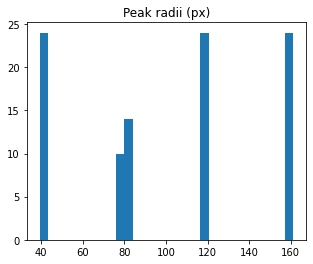

In [7]:

THRESH_ABS=0.4; 
MIN_DIST=5
H,W=saed.shape; 
mask=saed>=THRESH_ABS

if HAS_SCIPY:
    neigh_max=ndimage.maximum_filter(saed, size=2*MIN_DIST+1, mode='nearest')
else:
    pad=MIN_DIST; padimg=np.pad(saed,pad,mode='edge'); 
    neigh_max=np.zeros_like(saed)
    for i in range(H):
        for j in range(W):
            neigh_max[i,j]=np.max(padimg[i:i+2*pad+1, j:j+2*pad+1])

peaks_mask=(saed==neigh_max)&mask
ys,xs=np.where(peaks_mask)
plt.figure(figsize=(5,5)); 
plt.imshow(saed); 
plt.scatter(xs,ys,s=20,facecolors='none',edgecolors='r');
plt.title("Detected peaks");
plt.axis('off'); 
plt.show()

cy,cx=np.array(saed.shape)//2;
r_pix=np.sqrt((ys-cy)**2+(xs-cx)**2)

# do they need to be set by user?
camera_length_m=0.8; 
pixel_size_m=1e-5;
electron_lambda_m=2.51e-12
theta=(r_pix*pixel_size_m)/camera_length_m
d_est=electron_lambda_m/np.maximum(theta,1e-12)

import csv
with open('ex2_peaks.csv','w',newline='') as f:
    w=csv.writer(f); w.writerow(['y','x','r_pixels','d_est_m'])
    for yy,xx,rr,dd in zip(ys,xs,r_pix,d_est): 
        w.writerow([int(yy),int(xx),float(rr),float(dd)])
print("Saved ex2_peaks.csv (first 5):")
print([['y','x','r_pixels','d_est_m']]+[[int(ys[i]),int(xs[i]),float(r_pix[i]),float(d_est[i])] for i in range(min(5,len(ys)))])
plt.figure(figsize=(5,4)); 
plt.hist(r_pix,bins=30); 
plt.title("Peak radii (px)"); 
plt.show()


## Exercise 4 — Unsupervised clustering for defect identification

In this example we use use KMeans or DBSCAN to group similar contrast regions in STEM-HAADF images to detect dislocations, voids, or precipitates.


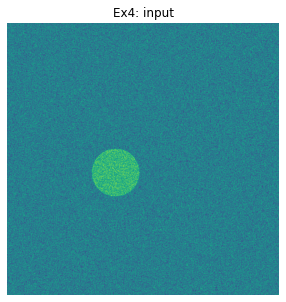

In [8]:
# check if the path exists
if EX4_IMAGE_PATH:
    try: img4=imread_gray(EX4_IMAGE_PATH)
    except Exception as e: 
        print("EX4 read failed, using synthetic.", e); 
        EX4_IMAGE_PATH=""

if not EX4_IMAGE_PATH:
    H,W=512,512; 
    rng=np.random.default_rng(2);
    base=rng.normal(0.5,0.08,(H,W))
    cy,cx,r=int(H*0.55),int(W*0.40),45; 
    yy,xx=np.ogrid[:H,:W];
    m=(yy-cy)**2+(xx-cx)**2<=r**2
    base[m]+=0.2; 
    img4=np.clip(base,0,1)
show_image(img4, "Ex4: input")


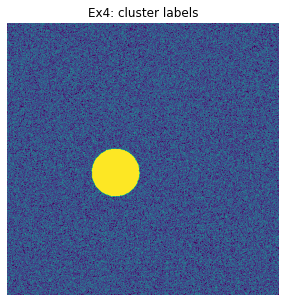

In [9]:
# features: intensity, local mean, local std, laplacian
if HAS_SCIPY:
    lm=ndimage.uniform_filter(img4,5)
    lsq=ndimage.uniform_filter(img4**2,5)
    lstd=np.sqrt(np.maximum(lsq-lm**2,0))
    lap=ndimage.laplace(img4)
else:
    k=np.ones((5,5))/25.0; 
    pad=2; 
    H,W=img4.shape; 
    padimg=np.pad(img4,pad,mode='edge')
    lm=np.zeros_like(img4); 
    lsq=np.zeros_like(img4)
    for i in range(H):
        for j in range(W):
            lm[i,j]=np.sum(padimg[i:i+5,j:j+5]*k)
    padimg2=np.pad(img4**2,pad,mode='edge')
    for i in range(H):
        for j in range(W):
            lsq[i,j]=np.sum(padimg2[i:i+5,j:j+5]*k)
    lstd=np.sqrt(np.maximum(lsq-lm**2,0))
    kern=np.array([[0,1,0],[1,-4,1],[0,1,0]],float); pad=1; p=np.pad(img4,pad,mode='edge'); lap=np.zeros_like(img4)
    for i in range(H):
        for j in range(W):
            lap[i,j]=np.sum(p[i:i+3,j:j+3]*kern)
feat=np.stack([img4,lm,lstd,lap],axis=-1)
X=feat.reshape(-1,4); Xmu=X.mean(0,keepdims=True); Xstd=X.std(0,keepdims=True)+1e-12; Xn=(X-Xmu)/Xstd
K=3
if HAS_SKLEARN:
    km=KMeans(n_clusters=K,n_init=10,random_state=0); labels=km.fit_predict(Xn)
else:
    rng=np.random.default_rng(0); centers=Xn[rng.choice(Xn.shape[0],K,replace=False)]
    for _ in range(15):
        d2=((Xn[:,None,:]-centers[None,:,:])**2).sum(2); labels=d2.argmin(1)
        for k in range(K):
            idx=labels==k
            if np.any(idx): centers[k]=Xn[idx].mean(0)
labels_img=labels.reshape(img4.shape)
show_image(labels_img, "Ex4: cluster labels")


## Exercise 5 — Principal Component Analysis (PCA) for EELS/EDS Spectrum Imaging

We perform PCA on spectrum image datasets (3D arrays: x, y, energy) to denoise and separate overlapping chemical signals.

cube: (40, 40, 100)


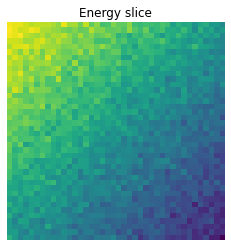

In [10]:
def load_cube(path, csv_shape=None):
    if not path: return None
    import os
    ext=os.path.splitext(path)[1].lower()
    if ext=='.npy': return np.load(path)
    if ext=='.npz':
        d=np.load(path)
        for k in d.files: return d[k]
    if ext=='.csv':
        assert csv_shape is not None, "Provide EX5_CSV_SHAPE for CSV."
        arr=np.loadtxt(path, delimiter=','); return arr.reshape(csv_shape)
    raise ValueError('Unsupported format: '+ext)

cube=None
if EX5_CUBE_PATH:
    try: cube=load_cube(EX5_CUBE_PATH, EX5_CSV_SHAPE)
    except Exception as e: 
        print("EX5 read failed, using synthetic.", e)

if cube is None:
    rows,cols,E=40,40,100; 
    x=np.linspace(0,1,cols,endpoint=False);
    y=np.linspace(0,1,rows,endpoint=False)
    X,Y=np.meshgrid(x,y); 
    peakA,peakB=0.35,0.65; 
    width=0.06
    
    def g(c,w,grid): 
        return np.exp(-0.5*((grid-c)/w)**2)
    
    energy=np.linspace(0,1,E,endpoint=False); 
    specA=g(peakA,width,energy); 
    specB=g(peakB,width,energy)
    mix=(X+Y)/2.0; rng=np.random.default_rng(123)
    cube=np.zeros((rows,cols,E))
    for i in range(rows):
        for j in range(cols):
            cube[i,j,:]=(1-mix[i,j])*specA+mix[i,j]*specB
    cube+=rng.normal(0,0.05,size=cube.shape)
print("cube:", cube.shape)
plt.figure(figsize=(5,4)); plt.imshow(cube[:,:,int(cube.shape[-1]*0.35)]); plt.title("Energy slice"); plt.axis('off'); plt.show()


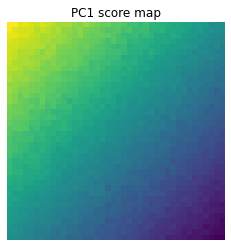

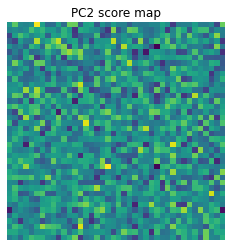

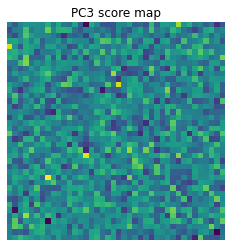

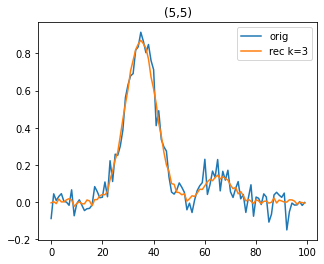

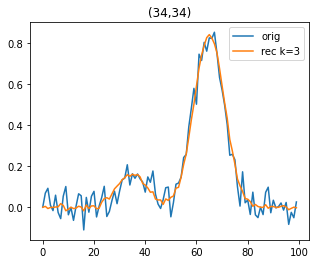

In [11]:

rows,cols,E=cube.shape; X=cube.reshape(-1,E); Xmean=X.mean(0,keepdims=True); Xc=X-Xmean; k=3
if HAS_SKLEARN:
    p=PCA(n_components=k, random_state=0);
    scores=p.fit_transform(Xc);
    pcs=p.components_
else:
    U,S,Vt=np.linalg.svd(Xc, full_matrices=False);
    pcs=Vt[:k,:]; scores=U[:,:k]*S[:k]
    
Xrec=scores@pcs+Xmean; 
cube_rec=Xrec.reshape(rows,cols,E)
for i in range(k):
    plt.figure(figsize=(4.5,4));
    plt.imshow(scores[:,i].reshape(rows,cols)); 
    plt.title(f"PC{i+1} score map"); 
    plt.axis('off');
    plt.show()

def compare(r,c):
    plt.figure(figsize=(5,4));
    plt.plot(cube[r,c,:],label='orig'); 
    plt.plot(cube_rec[r,c,:],label=f'rec k={k}');
    plt.legend(); plt.title(f'({r},{c})');
    plt.show()
    
compare(5,5); compare(rows-6, cols-6)


## Conclusions